# Measure the performance of the model conversion

The motivation of this notebook is that we want to measure the performance of the GGML runtime compared to the Torch runtime. We will do this by converting a model from Torch to GGML and then measuring the runtime of the forward pass for both the GGML and Torch versions of the model.

In [1]:
import json
from pathlib import Path

import pandas as pd
import seaborn as sns

In [2]:
sns.set_context("talk")
sns.set_style("white")

In [3]:
df = pd.DataFrame(
    # to get the `results.jsonl` file, run `make clean measure_performance` in the root of the repo
    [json.loads(line) for line in Path("../models/results.jsonl").read_text().splitlines() if line.strip()]
)

In [4]:
df

,torch,ggml,ggml_forward,input_dim,hidden_dim,num_blocks,batch_size,num_iters
0,0.000567,0.003652,0.001293,128,512,4,32,1000
1,0.000922,0.005952,0.001500,256,512,4,32,1000
2,0.001776,0.010367,0.002187,512,512,4,32,1000
3,0.004070,0.017888,0.003509,1024,512,4,32,1000
4,0.008738,0.036262,0.008000,2048,512,4,32,1000
5,0.001186,0.004719,0.002553,128,512,8,32,1000
6,0.002069,0.008422,0.003074,256,512,8,32,1000
7,0.004422,0.013528,0.004348,512,512,8,32,1000
8,0.019782,0.054303,0.023224,2048,512,8,32,1000
9,0.002266,0.007092,0.005127,128,512,16,32,1000


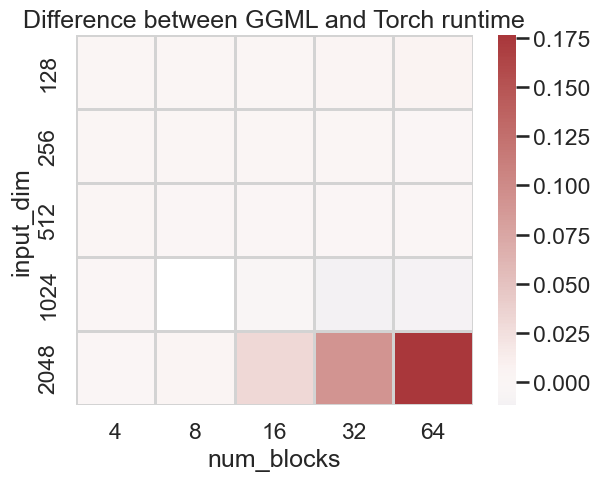

In [5]:
# negative numbers mean GGML is faster
ax = sns.heatmap(
    df.assign(diff=df["ggml_forward"] - df["torch"])
    .pivot_table(
        index="input_dim",
        columns="num_blocks",
        values="diff",
    ),
    cmap="vlag",
    center=0,
    linecolor="lightgray",
    linewidths=1,
)
ax.set_title("Difference between GGML and Torch runtime")
ax.set_facecolor("white")

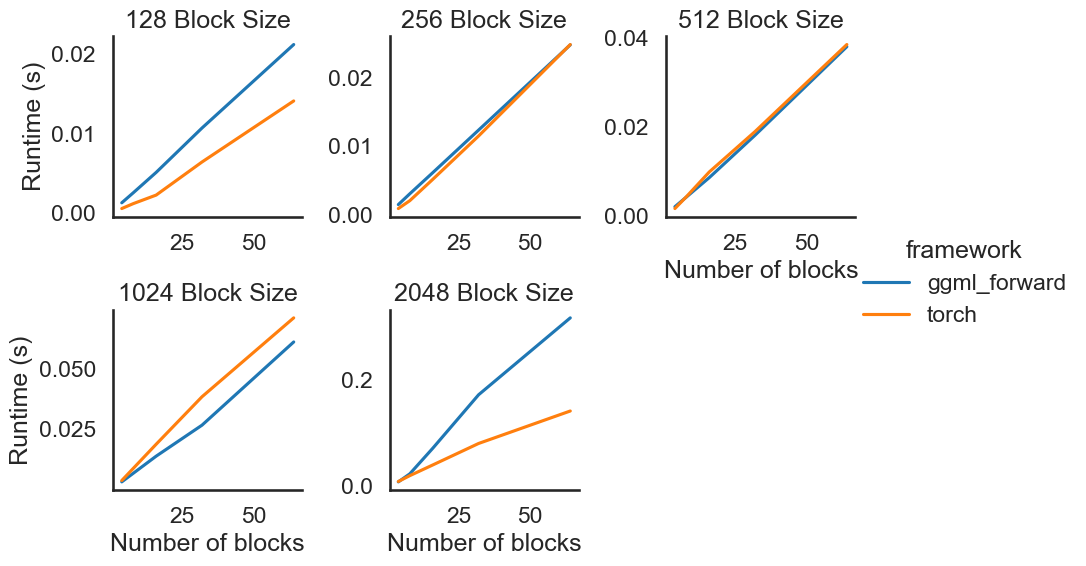

In [6]:
grid = sns.FacetGrid(
    df.melt(
        id_vars=["input_dim", "num_blocks"],
        value_vars=["ggml_forward", "torch"],
        var_name="framework",
        value_name="runtime",
    ),
    col="input_dim",
    hue="framework",
    col_wrap=3,
    sharey=False,
    sharex=False,
    margin_titles=True,
)
grid.map(
    sns.lineplot,
    "num_blocks",
    "runtime",
)
grid.set_titles(col_template="{col_name} Block Size")
grid.set_axis_labels("Number of blocks", "Runtime (s)")
grid.add_legend()

## Conclusion

We can see from the above that GGML provides most of its benefits at greater scale. For small models, the overhead of the GGML runtime is significant. However, as the model size increases, the GGML runtime becomes more efficient than the Torch runtime. This is because the GGML runtime is able to pre-allocate all the memory it needs for the entire model, whereas the Torch runtime must allocate memory as it goes. This is a significant advantage for large models, as it means that the GGML runtime can avoid the overhead of memory allocation during the forward pass.